In [1]:
import numpy as np
from scipy.signal import stft
import matplotlib.pyplot as plt

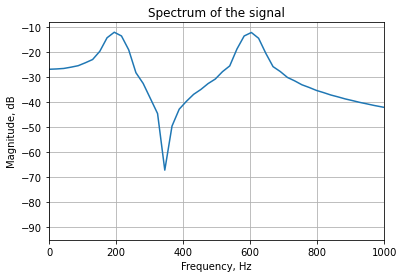

In [2]:
class Signal:
    def __init__(self, f=[200, 600], T=60, fs=44100):
        self.f = f
        self.fs = fs
        self.T = T

    # function for signal generating
    def generate(self):
        t = np.linspace(0, self.T, self.T*self.fs)
        s1 = np.zeros_like(t)
        for i in range(len(self.f)):
            s1 += np.sin(2*np.pi*self.f[i]*t)
        return t, s1

    # Function for STFT nperseq = number of samples in fft block, nfft = number of FFT points(number of subbands)
    def STFT(self, nsamples=1024, nfft=1024):
        t, s1 = self.generate()
        freq, time, z = stft(s1, self.fs, window="hann", nperseg=2*nsamples, nfft=nfft)
        return  freq, time, z

    # Function for converting freq in Herz to the corresponding bark scale
    def hz2bark(self, f):
        brk = 6. * np.arcsinh(f/600.)
        return brk

    # Reverse to function above
    def bark2hz(self, Brk):
        Fhz = 600. * np.sinh(Brk/6.)
        return Fhz

    # Prepairing W matrix to convert frequencies from STFT to bark scale from 0 to 24
    def mapping2barkmat(self, nfft=2048, nfilts=48):
        maxbark = self.hz2bark(self.fs/2) # for 22100 Hz max bark is 24
        step_barks = maxbark/(nfilts-1)
        binbarks = self.hz2bark(np.linspace(0,(nfft//2),(nfft//2)+1)*self.fs//nfft)
        W = np.zeros((nfilts, nfft))
        for i in range(nfilts):
            W[i,0:(nfft//2)+1] = (np.round(binbarks/step_barks)== i)
        return W

    # Transforming spectrum(STFT) from frequency domain to the bark domain with power saving
    def mapping2bark(self, nfft=2048, nfilts=48):
        W = self.mapping2barkmat(nfft, nfilts)
        [freq, time, mX] = self.STFT(nfft=nfft)
        nfreqs=int(nfft/2)
        mXbark = (np.dot(W[:, :nfreqs], np.abs(mX[:nfreqs, :])**2.0))**(0.5)
        return mXbark

    # Prepairing spreading function
    def f_SP_dB(self, maxfreq=44100/2, nfilts=48):
        maxbark = self.hz2bark(maxfreq) #upper end of our Bark scale:22 Bark at 16 kHz
        spreadingfunctionBarkdB=np.zeros(2*nfilts)
        spreadingfunctionBarkdB[0:nfilts]=np.linspace(-maxbark*27,-8,nfilts)-23.5
        spreadingfunctionBarkdB[nfilts:2*nfilts]=np.linspace(0,-maxbark*12.0, nfilts)-23.5
        return spreadingfunctionBarkdB

    # Spreading function in matrix form for whole bark range
    def spreadingfunctionmat(self, alpha=0.6, nfilts=48):
        spreadingfunctionBarkdB = self.f_SP_dB(self.fs/2, nfilts)
        spreadingfunctionBarkVoltage = 10.0**(spreadingfunctionBarkdB/20.0*alpha)
        spreadingfuncmatrix = np.zeros((nfilts,nfilts))
        for k in range(nfilts):
            spreadingfuncmatrix[k,:]=spreadingfunctionBarkVoltage[(nfilts-k):(2*nfilts-k)]
        return spreadingfuncmatrix

    # Calculating masking threshold vector for all time moments (resulting in matrix)
    def maskingThresholdBark(self, alpha=0.6, nfilts=48):
        mXbark = self.mapping2bark()
        spreadingfuncmatrix = self.spreadingfunctionmat(alpha, nfilts)
        mTbark=np.dot(spreadingfuncmatrix**alpha, mXbark**alpha)
        mTbark=mTbark**(1.0/alpha)
        maxfreq=self.fs/2.0
        maxbark=self.hz2bark(maxfreq)
        step_bark = maxbark/(nfilts-1)
        barks=np.arange(0, nfilts)*step_bark
        f=self.bark2hz(barks)+1e-6
        LTQ=np.clip((3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.-3.3)**2.)+1e-3*((f/1000.)**4.)),-20,160)
        for i in range(mXbark.shape[1]): # over all time moments
            mTbark[:, i] = np.max((mTbark[:, i], 10.0**((LTQ-60)/20)), 0)
        return mTbark

    # Preparing matrix W_inv to convert masking from bark scale to linear(frequency) scale
    def mappingfrombarkmat(self, nfft=2048, nfilts=48):
        W = self.mapping2barkmat(nfft, nfilts)
        nfreqs=int(nfft/2)
        W_inv= np.dot(np.diag((1.0/np.sum(W, 1))**0.5), W[:,0:nfreqs + 1]).T
        return W_inv

    # converting
    def mappingfrombark(self, nfft=2048, nfilts=48):
        W_inv = self.mappingfrombarkmat(nfft, nfilts)
        mTbark = self.maskingThresholdBark()
        nfreqs=int(nfft/2)
        mT = np.dot(W_inv[:nfreqs, :], mTbark)
        return mT

    # converting in quiet
    def mappingfrombarkQUIET(self, nfft=2048, nfilts=48, alpha=0.6):
        W_inv = self.mappingfrombarkmat(nfft, nfilts)
        mTbark = self.maskingThresholdBark()
        nfreqs=int(nfft/2)
        mTq = np.dot(W_inv[:nfreqs, :], mTbark)
        mTq = mTq**(1/alpha)
        return mTq


# Generate signal
S = Signal([200, 600], 180, 44100)
# spectrum (actually spectrogram in freq-time domain)
# but we plot only for 1 time moment
[freqs, time, z] = S.STFT(1024, 2048)
plt.plot(np.linspace(0, 44100/2, 1024), 20*np.log10(np.abs(z[:1024, 0])))
plt.xlim((0, 1000))
plt.title('Spectrum of the signal')
plt.xlabel('Frequency, Hz')
plt.ylabel('Magnitude, dB')
plt.grid(True)

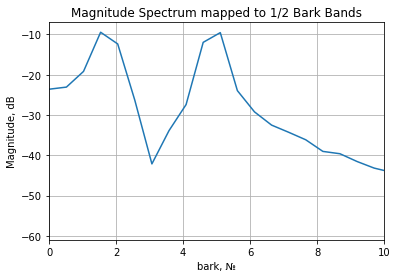

In [3]:
# converting spectrum to bark scale
mXbark = S.mapping2bark()
plt.plot(np.linspace(0, 24, 48), 20*np.log10(mXbark[:, 0] + 1e-3))
plt.xlim((0, 10))
plt.title('Magnitude Spectrum mapped to 1/2 Bark Bands')
plt.xlabel('bark, №')
plt.ylabel('Magnitude, dB')
plt.grid(True)

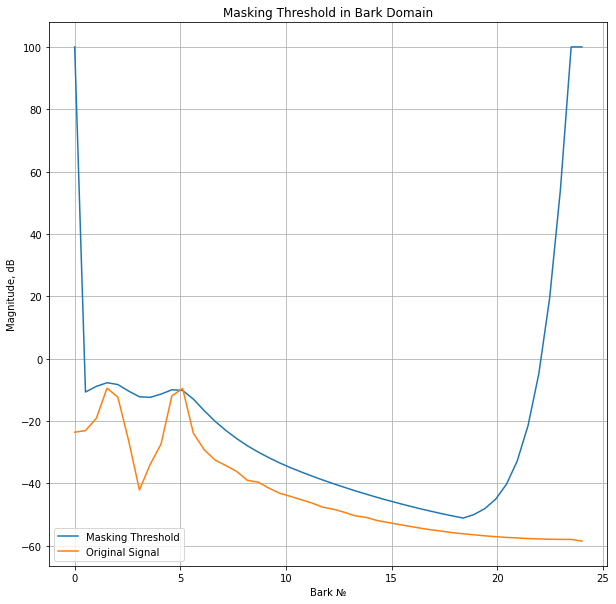

In [4]:
# calculate masking threshold in bark domain
mTbark = S.maskingThresholdBark()
#mTbark.shape
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(np.linspace(0, 24, 48), 20*np.log10(mTbark[:, 0]+1e-3))
ax.plot(np.linspace(0, 24, 48), 20*np.log10(mXbark[:, 0] + 1e-3))
ax.legend(['Masking Threshold','Original Signal'])
ax.set_title('Masking Threshold in Bark Domain')
ax.set_xlabel('Bark №')
ax.set_ylabel('Magnitude, dB')
ax.grid(True)

Text(0, 0.5, 'Magnitude, dB')

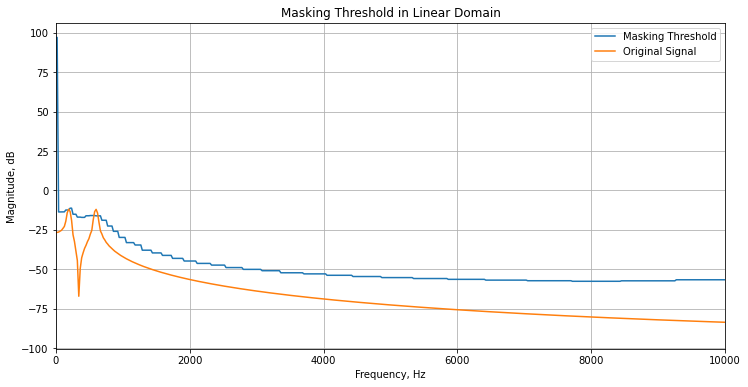

In [5]:
# converting masking threshold from bark to linear(frequency) domain
mT = S.mappingfrombark()
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.linspace(0, 44100/2, 1024), 20*np.log10(mT[:, 0]+1e-3))
ax.plot(np.linspace(0, 44100/2, 1024), 20*np.log10(np.abs(z[:1024, 0])))
plt.xlim((0, 10000))
plt.grid(True)
ax.legend(['Masking Threshold','Original Signal'])
ax.set_title('Masking Threshold in Linear Domain')
ax.set_xlabel('Frequency, Hz')
ax.set_ylabel('Magnitude, dB')

Text(0, 0.5, 'Magnitude, dB')

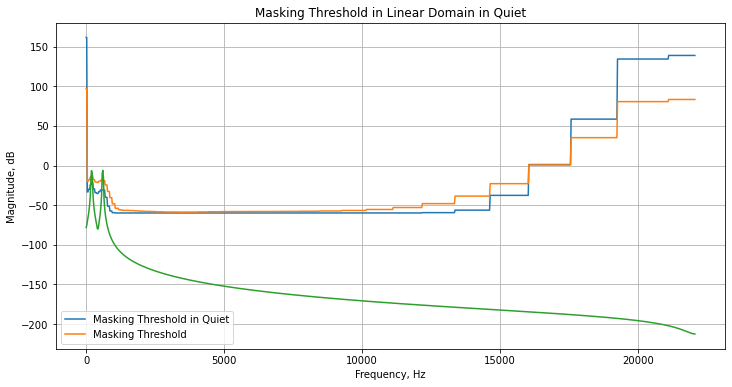

In [6]:
# same for quiet case
fig, ax = plt.subplots(figsize=(12, 6))
mTq = S.mappingfrombarkQUIET()
ax.plot(np.linspace(0, 44100/2, 1024), 20*np.log10(mTq[:, 10]+1e-3))
ax.plot(np.linspace(0, 44100/2, 1024), 20*np.log10(mT[:, 10]+1e-3))
ax.plot(np.linspace(0, 44100/2, 1024), 20*np.log10(np.abs(z[:1024, 10])))
#plt.xlim((0, 5000))
plt.grid(True)
ax.legend(['Masking Threshold in Quiet', 'Masking Threshold'])
ax.set_title('Masking Threshold in Linear Domain in Quiet')
ax.set_xlabel('Frequency, Hz')
ax.set_ylabel('Magnitude, dB')